# Autoencoder
First of all we load the libraries we need.

In [54]:
# load all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

Now we actually load the data, taking care to read the 'Data' column as datetime and all other columns as float (we previously manually modified the data to be compatible with this).

i.e.
we deleted the '.' from the thousands separator and replace the ',' with '.' for the decimal separator.

Furthermore we use ';' as the separator.

In [55]:
# load the data from the file 'EWS.csv', delimiter is ';', read column 'Data' as datetime and all others as floats
data = pd.read_csv('EWS.csv', delimiter=';', parse_dates=['Data'], dayfirst=True)

# only take the first column of the data as Y
Y = data.iloc[:,0]

# take the rest of the columns as X
X = data.iloc[:,1:]
# convert the 'Data' column from datetime to int
X['Data'] = X['Data'].astype(np.int64)

Now we do some basic data exploration to see what we are dealing with.

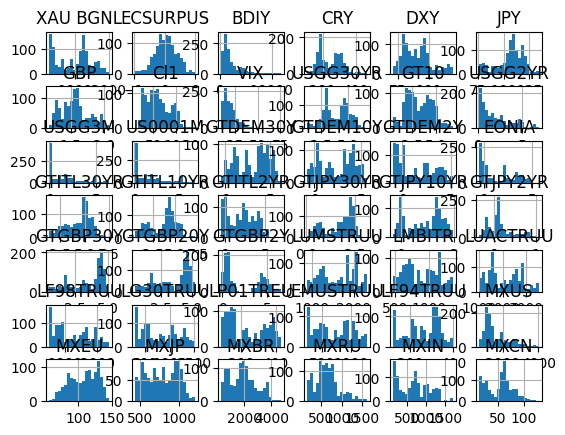

In [56]:
# create histogram for each column in DataFrame except the first one ('Data')
X.iloc[:,1:].hist(bins=20)
plt.show()

Now we try to normalize the data by zscore.

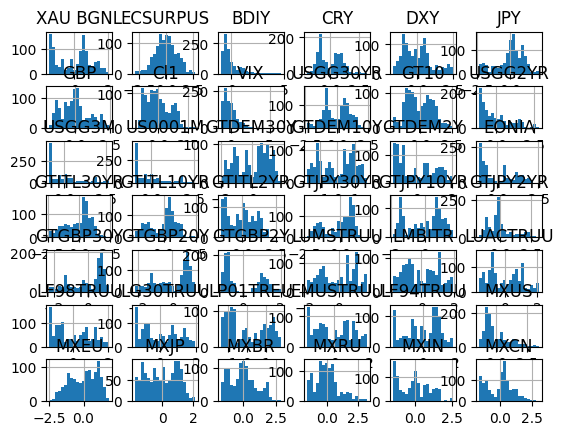

In [57]:
# normalize the data by zscoring
X = (X - X.mean()) / X.std()
# replot the histograms
X.iloc[:,1:].hist(bins=20)
plt.show()

Split the data between training and test set.

In [58]:
# split the data into training and test set (80% training, 20% test)

# first shuffle the data (both X and Y, but keep the order of X and Y the same)
# create a random permutation of the indices of X
permutation = np.random.permutation(X.index)
# shuffle X and Y according to the permutation
X = X.reindex(permutation)
Y = Y.reindex(permutation)

# split the data into training and test set
# take the first 80% of the data as training set
train_size = int(0.8*len(X))
X_train = X.iloc[:train_size,:]
Y_train = Y.iloc[:train_size]
# take the rest of the data as test set
X_test = X.iloc[train_size:,:]
Y_test = Y.iloc[train_size:]

We now pass to define the model.

We the layers as follows:

1. Encoder:

- Input layer: 1 neuron for each feature (i.e. 1 neuron for each column of the data) (we exclude the 'Data' column)

- Hidden layer: 4 neurons with relu activation function

- Output layer (Encoded layer): 4 neurons with relu activation function

2. Decoder:

- Hidden layer: 4 neurons with relu activation function

- Output layer (Decoded layer): 1 neuron for each feature (i.e. 1 neuron for each column of the data)



In [59]:
# Define the autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 4
hidden_dim = 8

#create the various layers of the model
# input layer with input_dim neurons
input_layer = Input(shape=(input_dim,))
# first hidden layer with hidden_dim neurons
hidden_layer_1 = Dense(hidden_dim, activation='relu')(input_layer)
# encoded layer with encoding_dim neurons
encoded_layer = Dense(encoding_dim, activation='relu')(hidden_layer_1)
# second hidden layer with hidden_dim neurons
hidden_layer_2 = Dense(hidden_dim, activation='relu')(encoded_layer)
# output layer with input_dim neurons
output_layer = Dense(input_dim)(hidden_layer_2)

model = Model(input_layer, output_layer)
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 43)]              0         
                                                                 
 dense_28 (Dense)            (None, 8)                 352       
                                                                 
 dense_29 (Dense)            (None, 4)                 36        
                                                                 
 dense_30 (Dense)            (None, 8)                 40        
                                                                 
 dense_31 (Dense)            (None, 43)                387       
                                                                 
Total params: 815
Trainable params: 815
Non-trainable params: 0
_________________________________________________________________


Now we compile and train the model.

In [60]:
# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=1000, verbose=1)
model.fit(X_train, X_train, epochs=100, batch_size=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
8/8 [==============================] - 1s 18ms/step - loss: 1.1688 - val_loss: 1.0832
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 1.1053 - val_loss: 1.0357
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 1.0621 - val_loss: 1.0027
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 1.0306 - val_loss: 0.9750
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 1.0017 - val_loss: 0.9466
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 0.9697 - val_loss: 0.9131
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 0.9328 - val_loss: 0.8727
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 0.8896 - val_loss: 0.8297
Epoch 9/100
8/8 [==============================] - 0s 5ms/step - loss: 0.8440 - val_loss: 0.7893
Epoch 10/100
8/8 [==============================] - 0s 5ms/step - loss: 0.8024 - val_loss: 0.7513
Epoch 11/100
8/8 [==========

In [61]:
# Make prediction
prediction_test = model.predict(X_test)
# Evaluate the model on test set
reconstruction_errors = np.mean(np.power(X_test - model.predict(X_test), 2), axis=1)
reconstruction_errors_train = np.mean(np.power(X_train - model.predict(X_train), 2), axis=1)

28/28 [==============================] - 0s 1ms/step


In [62]:
# Set threshold based on reconstruction error distribution of inlier samples
threshold = np.percentile(reconstruction_errors_train, 97.5)
anomalies = np.where(reconstruction_errors > threshold)[0]
normal = np.where(reconstruction_errors <= threshold)[0]
print(f"{len(anomalies)} anomalies and {len(normal)} normal samples detected.")

5 anomalies and 218 normal samples detected.
